# Geospatial LiveProject Milestone 1

This Jupyter Notebook is the first milestone deliverable for a Manning liveProject called [Monitoring Changes in Surface Water Using Satellite Image Data](https://www.manning.com/liveproject/monitoring-changes-in-surface-water-using-satellite-image-data).   

I am excited about the project. Satellite datasets are available for free from the European Space Agency (ESA) and from NASA.  I'm excited to learn the workflows necessary to get this information, process it, and analyze it in ways that allow for tangible real-world insights.  

In general, I'm trying to sharpen my skills for working with unstructured data.   Previously I've done an initial dive into Natural Language Processing (NLP) to analyze text data.   Actually working with the data gives one an intuition of what kinds of real-world problems can and cannot be solved.  It also gives one a sense of what areas are low-hanging-fruit that can perhaps be approached as a personal project, and what would require serious infrastructure and computing capacity.

## The Deliverable

The requirements for the first milestone deliverable are to post a Jupyter Notebook on Github:
* demonstrating reading in a satelite dataset using [rasterio](https://rasterio.readthedocs.io/en/latest/)
* demonstrate a function that carries out a manipulation of that image using Keras/Tensorflow.


## Other Things I've Learned in the Process

While the deliverable is relatively straightforward, this week I've learned a lot more that I'm excited about.  
* __Conda Environments:__ I learned how to set up Conda environments, and I'm running this in a Conda environment.  Here's a guide to [Conda](https://towardsdatascience.com/a-guide-to-conda-environments-bc6180fc533).   
* __Deep Learning + Keras/Tensorflow:__ The course assumes some knowledge of creating deep learning models using Keras/Tensorflow.  I have no experience with that, so I did two DataCamp courses this week related to that, and now I feel like I have a good (very basic) understanding both conceptually and practically about Deep Learning and how to build Convolutional Neural Network models in Keras. The two courses were 1) [Introduction to Deep Learning in Python](https://learn.datacamp.com/courses/introduction-to-deep-learning-in-python), and 2) [Image Processing with Keras in Python](https://learn.datacamp.com/courses/image-processing-with-keras-in-python)
* __Git + Github:__ I'm learning how to post Jupyter Notebooks on Github.  On a day-to-day basis, I have traditionally used R, and work largely with economic and financial data.  As I have been imporoving my data science workflows, I've started version controlling my projects to git, and recently posted my first rudimentary R package on Github.  As I try to develop healthy python workflows, this will be my first time version controlling Python projects and posting them to Github. 
* __Working with raster data__:  As part of the homework, I read chapters 9-11 of [Geoprocessing with Python](https://www.manning.com/books/geoprocessing-with-python). Being new to geospatial analysis, I found it to be a useful introduction to understanding raster data, which will be a key part of this project. The other unintended consequence is that it taught me to be very thankful for the [Rasterio](https://rasterio.readthedocs.io/en/latest/) Python package.  My understanding (I'm new to this) is that Rasterio is built on top of [GDAL](https://gdal.org/python/), which has been around for a very long time.  GDAL has a lot of powerful functionality, but the python package seems to be just a thin wrapper around an original C++ package, and it shows.   Rasterio makes using GDAL's functionality much easier and more "Pythonic". 


__Big Picture__ Complicated problems can generally be decomposed into simple component parts. The simple, but profound thing I learned this week was that image data are really just 3 dimensional arrays of pixels that can be represented numerically.   The first two dimensions are height and width.  The third dimension is the numeric representations of Red, Green, and Blue values that make up color photos.  The basis of all of the interesting analysis that we do is based upon breaking down images into numbers using this logic. 

# Part 1:  Uploading Satellite Data Using Rasterio

Initially, I had wanted to figure out the workflow to directly download satellite data using python, using [sentinalsat](https://sentinelsat.readthedocs.io/en/stable/api.html), or another package.  But I realize that I should approach this one step at a time -- figuring out how to convert filetypes can be a challenge the first time around.  The key point of this milestone is to read in a geoTIFF file using Rasterio, and do some basic analysis on it.  So I downloaded an image of New York City from the [USGS LandsatLook viewer](https://landsatlook.usgs.gov/viewer.html).

<img src="3A0D1534-5D9E-4AEF-9BD7-717618F904D1.png" width=1000 height=700 />

## Importing The GeoTIFF File using Rasterio

Since this is my first time working with this data type & with Rasterio, I'm starting by literally just following the workflow in the [rasterio python quickstart documentation](https://rasterio.readthedocs.io/en/latest/quickstart.html)

In [8]:
import rasterio

In [9]:
nyc_tif = rasterio.open('_ags_71655583_1aaf_4d42_9a2b_b153b676594d.tif')

### Dataset attributes

In [10]:
nyc_tif.count

3

This dataset has 3 bands.  Since it is a full color image, I am assuming that these are the Red, Green, and Blue bands.

In [13]:
nyc_tif.width

6104

In [14]:
nyc_tif.height

2817

The dataset has a width of 6,104 pixels, and a height of 2,817 pixels

In [15]:
{i: dtype for i, dtype in zip(nyc_tif.indexes, nyc_tif.dtypes)}

{1: 'uint8', 2: 'uint8', 3: 'uint8'}

Each of the three bands is an 8-bit integer value

### Dataset georeferencing

In [16]:
nyc_tif.bounds

BoundingBox(left=-8322650.208773671, bottom=4940857.166364487, right=-8139466.604782865, top=5025396.519647924)

These numbers are in meters.   I'll have to look up exactly what they reference, but you can calculate the size of the area by finding the difference between the top & bottom, and left & right bounds.

In [18]:
nyc_tif.affine

Affine(30.010420050918306, 0.0, -8322650.208773671,
       0.0, -30.01042005091834, 5025396.519647924)

This is the affine transfromation that maps pixel location in (row, col) coordinates to (x,y) spatial positions.   Notice that the third number correspons to the right bound above, and the size number corresponds to the top bound above.

Therefore, if you multiply this matrix by (0, 0) you'll get the coordinates of the upper left corner.

In [19]:
nyc_tif.affine * (0,0)

(-8322650.208773671, 5025396.519647924)

and if you multiply it by the dataset's height & width, you'll get the lower right hand corner (corresponding to the bottom bound and the right bound above).

In [20]:
nyc_tif.affine * (nyc_tif.width, nyc_tif.height)

(-8139466.604782865, 4940857.166364487)

In [21]:
nyc_tif.crs

CRS({'init': 'epsg:3857'})

The CRS is the Coordinate Reference System.   This image uses the [ESPG:3857](https://en.wikipedia.org/wiki/Web_Mercator_projection#EPSG:3857) Projection, which wikipedia tells me is another name for the Web Mercator WGS84 projection that is shown in the screenshot from the USGS LandsatLook viewer above.

In broad terms, a coordinate reference system is a way of mapping two dimensional representations of earth, like we see in this image, to the fact that the earth is round.   I'm new to this, so I'll just refer you to the [wikipedia article](https://en.wikipedia.org/wiki/Spatial_reference_system) explaining this.

The big picture:  The CRS + the other information shown above (affine transformation, bounds) allows us to precisely map all areas of this image to an exact location on the globe. It allows us to compare this image to other geospatial data.

### Reading raster data

In [22]:
nyc_tif.indexes

(1, 2, 3)

We can read these three raster layers in individually.  They will be integers between 0 and 255, in the form of a NumPy array, representing the intensity of the Red (Band 1), Green (Band 2), and Blue (Band 3) layers.

In [29]:
band1 = nyc_tif.read(1)
band2 = nyc_tif.read(2)
band3 = nyc_tif.read(3)

In [45]:
band1

array([[114, 109, 106, ...,  37,  37,  37],
       [111, 107, 107, ...,  37,  37,  37],
       [112, 111, 113, ...,  37,  37,  37],
       ...,
       [ 96,  96,  98, ...,  41,  41,  41],
       [ 94,  93,  94, ...,  41,  41,  41],
       [ 95,  91,  90, ...,  41,  41,  41]], dtype=uint8)

In [34]:
type(band1)

numpy.ndarray

In [44]:
band1.max()

254

In [42]:
band1.min()

4

We can plot each raster layer.  By default, matplotlib uses the [viridis](https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html) color palette, but remember, these represent the red, green, and blue layers of color.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

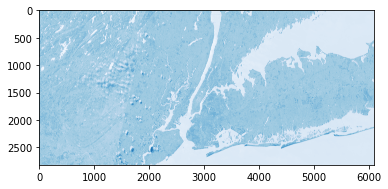

In [55]:
plt.imshow(band1, cmap='Blues')

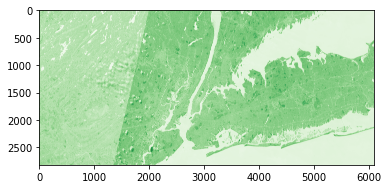

In [54]:
plt.imshow(band2, cmap='Greens')

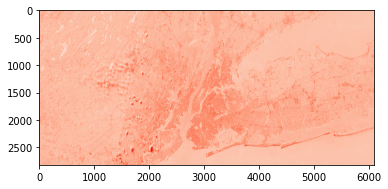

In [53]:
plt.imshow(band3, cmap='Reds')